Have a look later at multiparallel forecasting:
 https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/ 

In [1]:
from backend.models.model_nnext import ModelNNext
from configs.config import get_cfg
import matplotlib.pyplot as plt
import numpy as np

In [2]:
convolution = True

In [3]:
if convolution:
    cfg = get_cfg("model_finance_convo.yaml")
else:
    cfg = get_cfg("model_finance.yaml")
# Instantiate and print the model
model = ModelNNext(cfg, flat_input = not convolution)
model.prepare_data()

[*********************100%***********************]  5 of 5 completed


In [3]:
import pickle
with open('data-loaded_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [5]:
import pickle
with open('data-loaded_model.pkl', 'rb') as file:
    model = pickle.load(file)
model.cfg = get_cfg("model_finance.yaml")

In [4]:
model.build()

In [5]:
model.train()

Epoch: 0
Train - Loss: 98.8970
Valid - Loss: 61.3678
Epoch: 1
Train - Loss: 97.4375
Valid - Loss: 61.5078
Epoch: 2
Train - Loss: 94.8254
Valid - Loss: 61.0599
Epoch: 3
Train - Loss: 89.3577
Valid - Loss: 61.5022
Epoch: 4
Train - Loss: 81.7202
Valid - Loss: 61.5388
Epoch: 5
Train - Loss: 72.9385
Valid - Loss: 63.7151
Epoch: 6
Train - Loss: 66.2312
Valid - Loss: 63.9793
Epoch: 7
Train - Loss: 62.6986
Valid - Loss: 67.5662
Stopping early due to 5 many consecutive increases in validation loss. Loading back earlier model.


[[-0.13386361  0.06923558  0.01375028 -0.04259884 -0.18214007]
 [ 0.12110974  0.14840011  0.11680131  0.20900589  0.33322054]
 [-0.07696849  0.04368629 -0.00436561  0.03013453 -0.10585131]
 ...
 [-0.05522059  0.37301904  0.31114012  0.05475822 -0.07985354]
 [-0.43818375  0.17246126  0.02538067 -0.27049035 -0.4702536 ]
 [-0.25465113  0.03611529 -0.05151327 -0.11610258 -0.30995107]]
(250, 5)


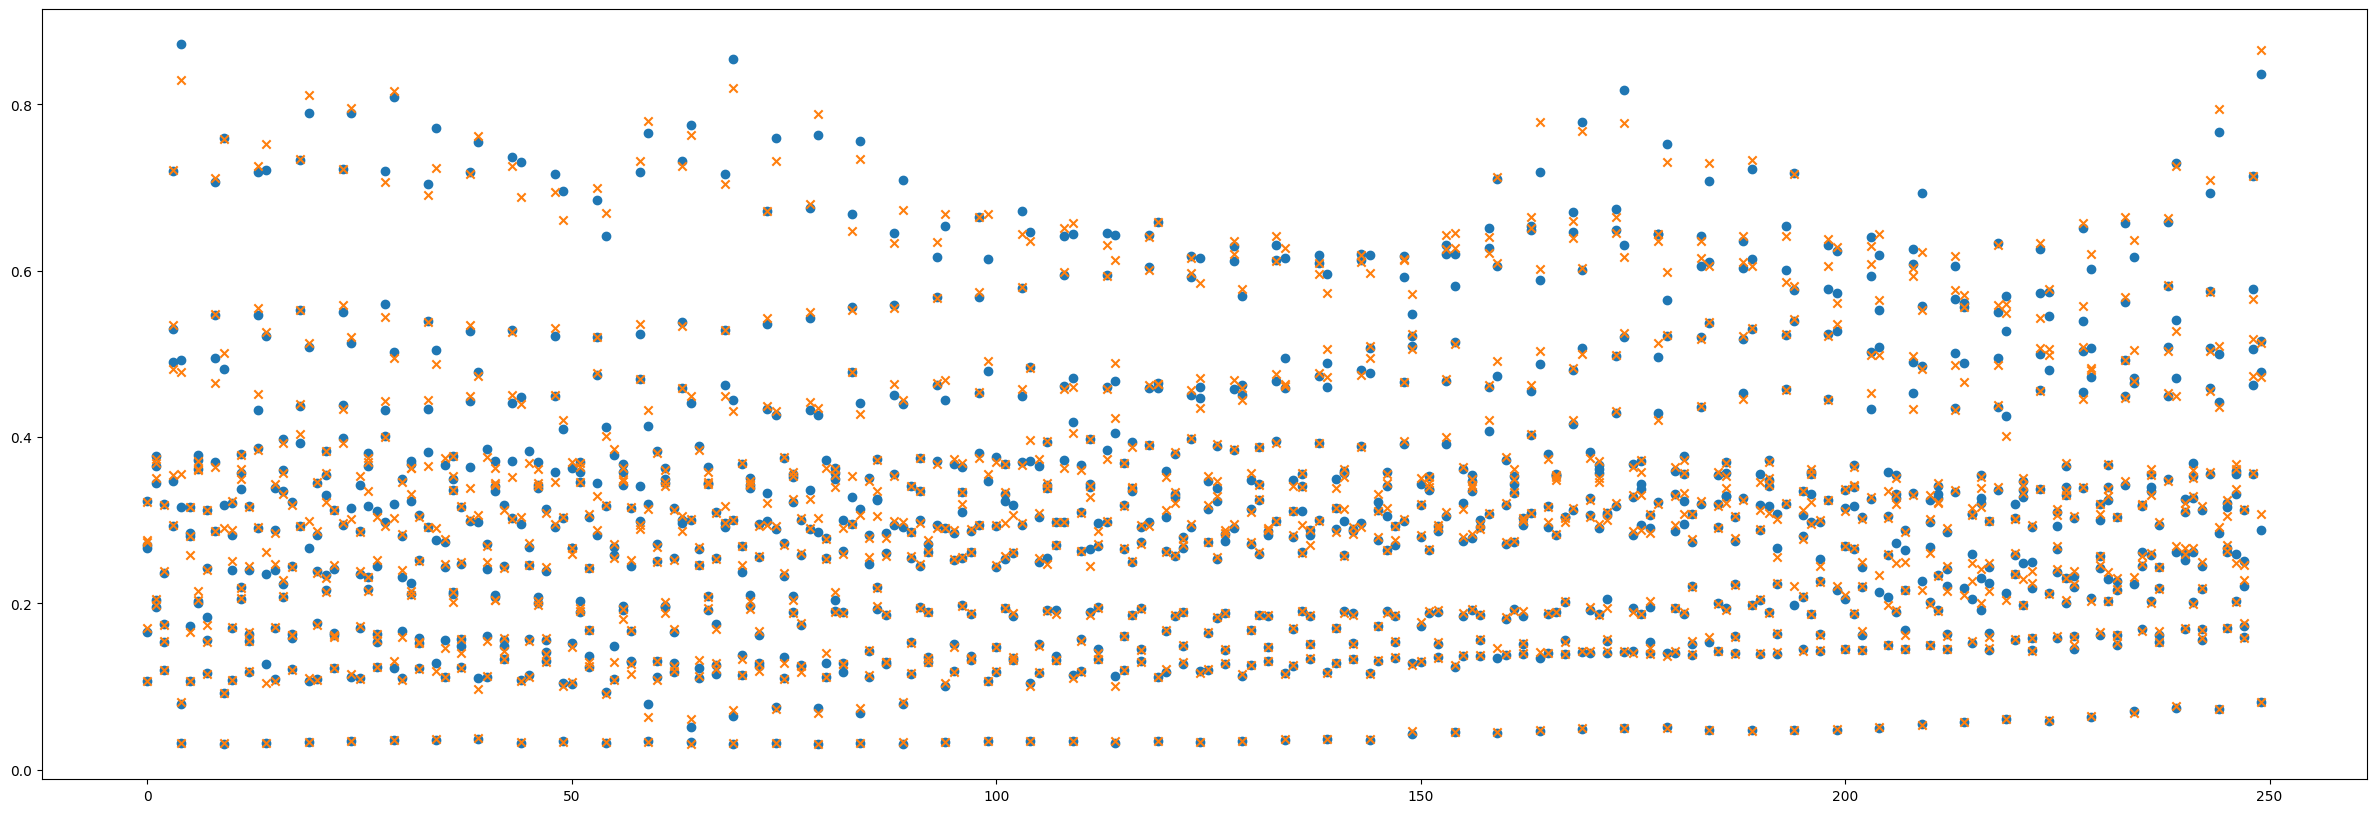

In [6]:
if convolution:
    Ypred = model.evaluate(model.data.X_test_set.tensor.unsqueeze(1)).numpy()
else:
    Ypred = model.evaluate(model.data.X_test_set.reshaped_2D_tensor()).numpy()
Ytrue = model.data.Y_test_set.ndarray
floorYtest = model.data.Ybis_test_set.ndarray

print(Ypred)
Ypred= (Ypred/100+1)*floorYtest
Ytrue= (Ytrue/100+1)*floorYtest

plt.figure(figsize=(30,10))
print(Ytrue.shape)
t = np.array([range(len(Ypred)) for i in range(len(Ypred[0]))])
plt.scatter(t,Ypred)
plt.scatter(t,Ytrue, marker='x')

# # plt.plot(range(n2,n1),full_pred_series,alpha = 0.7, linestyle='--')
plt.show()

[[ 0.7697549  -0.6262014  -3.90421476 -1.97334079 -0.65712345  0.        ]
 [ 0.67631048  1.17766526  1.69845703  1.12581996  3.14947768  0.        ]
 [ 1.37538062  1.24672738  3.12933464  1.03094704  2.65978235  0.        ]
 ...
 [ 5.89514351 12.76275688  7.72137247  3.41600922 14.71908437  0.        ]
 [-2.69890813  1.57726703  0.39794139 -1.00332923 -7.57772224  0.        ]
 [ 1.96227454 -1.09107491  2.23755011  0.29946947  3.30021411  0.        ]]


Text(0, 0.5, 'Cumulative returns (%)')

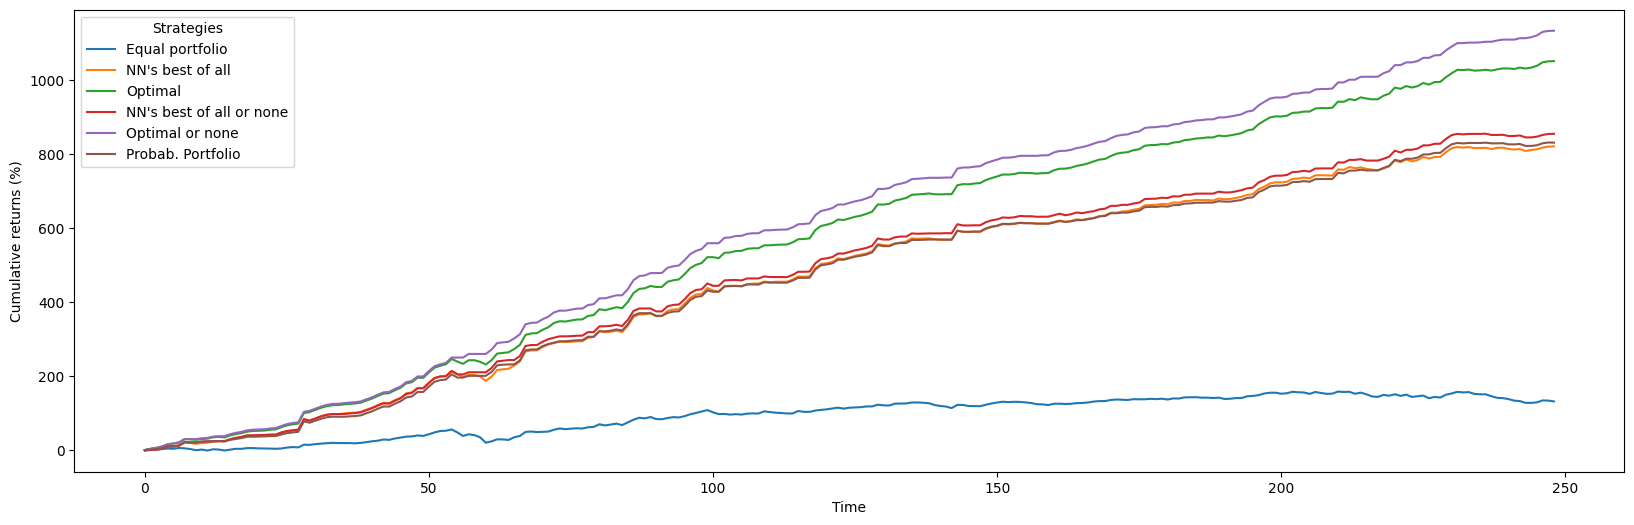

In [7]:
#### Return of the asset vs return on-off if up or down prediction.
import numpy as np
# Calculate percentage change
def pctc(arr):
  return np.diff(arr,axis = 0) / arr[:-1,:] * 100

PCa = pctc(Ytrue)
# PCb = np.copy(PCa)
# PCmax = np.copy(PCa)

temp = pctc(Ypred)
# PCb[temp<=0] = 0 # our prediction might tell us when to sell/buy (each time there is a increase/decrease pred)
# PCmax[PCa<=0] =0 # can't get more returns than when knowing the real time-series values and selling when decrease incoming.
PCmax = np.maximum.reduce(PCa,axis=1)
PCmax_and_cash = np.maximum(PCmax,0.0)

##
max_indices = np.argmax(temp, axis=1)

# PCb = PCa[:,max_indices]
PCb = PCa[np.arange(PCa.shape[0]), max_indices]

temp  = np.hstack((temp,np.zeros((temp.shape[0], 1))))
max_indices_with_zero = np.argmax(temp, axis=1)
PCa_and_cash = np.hstack((PCa,np.zeros((PCa.shape[0], 1))))

PCbBis = PCa_and_cash[np.arange(PCa_and_cash.shape[0]), max_indices_with_zero]

PCequal = np.sum(PCa,axis = 1)/len(PCa[0]) #if just having the same amount of each asset.

### invest proportionally to pred
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
print(temp)
PC_portfolio = np.exp(temp)*(temp>=0.0)
# PC_portfolio = temp
PC_portfolio = PC_portfolio/np.sum(PC_portfolio,axis=1)[:,np.newaxis]
PC_portfolio = np.sum(PCa_and_cash*PC_portfolio,axis = 1)

# cumulate the pct changes
PCequal = PCequal.cumsum()
PCb = PCb.cumsum()
PCmax = PCmax.cumsum()
PCbBis = PCbBis.cumsum()
PCmax_and_cash = PCmax_and_cash.cumsum()
PC_portfolio = PC_portfolio.cumsum()

# Plot
fig = plt.figure(figsize=(20,6))
plt.plot(PCequal)
plt.plot(PCb)
plt.plot(PCmax)
plt.plot(PCbBis)
plt.plot(PCmax_and_cash)
plt.plot(PC_portfolio)
plt.legend(['Equal portfolio',"NN's best of all",'Optimal', "NN's best of all or none", 'Optimal or none','Probab. Portfolio'], title = 'Strategies')
plt.xlabel('Time')
plt.ylabel('Cumulative returns (%)')

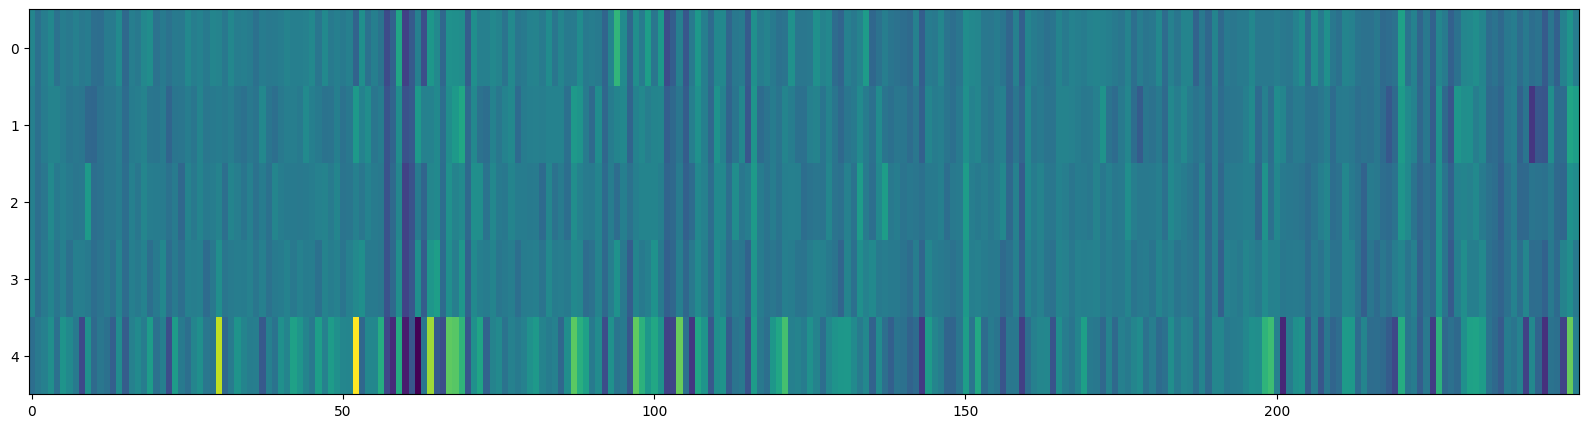

In [9]:
fig = plt.figure(figsize=(20,5))
plt.imshow(PCa.T,  aspect='auto')